In [1]:
import os
import re
import json
import codecs

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.preprocessing import normalize, StandardScaler

from metric_learn import ITML_Supervised, Covariance

In [2]:
dir_in_parsed = 'parsed_json_cut'
dir_in_raw = 'json_cut'

In [3]:
catalog = pd.read_csv('collection_catalog.csv', sep=';', usecols=['author_id', 'fbusta_id'])
with open('stop3grams.txt', 'r') as f:
    stop3grams = [s.lower() for s in f.read().splitlines()]

In [4]:
len(stop3grams)

576

In [5]:
def get_author(book_id, catalog):
    return catalog.loc[catalog['fbusta_id'] == book_id]['author_id'].item()

In [6]:
authors = []
for filename in sorted(os.listdir(dir_in_parsed)):
    with open(os.path.join(dir_in_parsed, filename), 'r') as book:
        book_id = int(filename.split('.')[0])
        authors.append(get_author(book_id, catalog))

In [7]:
len(authors)

633

In [8]:
groups = pd.Series(authors).value_counts()
singles = np.array(groups[groups==1].index)
singles

array([ 14,  68,  36, 107,  31])

In [9]:
authors = np.array([a for a in authors if a not in singles])
len(authors)

628

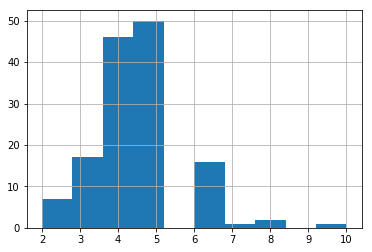

In [10]:
%matplotlib inline
pd.Series(authors).value_counts().hist()

### 3 pos граммы

In [11]:
def count_n_grams(texts, n=3, stopgrams=[]):
    cv = CountVectorizer(ngram_range=(n, n), token_pattern=u"(?u)\\b\\w+\\b")
    cv.fit(texts)
    for s in stopgrams:
        if s in cv.vocabulary_:
            del cv.vocabulary_[s]
    for i, s in enumerate(sorted(cv.vocabulary_)):
        cv.vocabulary_[s] = i
    transformed = cv.transform(texts)
    return transformed, cv

In [12]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_parsed)):
    with open(os.path.join(dir_in_parsed, filename), 'r') as book:
        book_id = int(filename.split('.')[0])
        if get_author(book_id, catalog) not in singles:
            data.append(book.read())

print(len(data))

tri_grams, cv_tri_grams = count_n_grams(data, n=3, stopgrams=stop3grams)
tri_grams = normalize(tri_grams, norm='l1')

628
CPU times: user 10.3 s, sys: 59.2 ms, total: 10.4 s
Wall time: 10.5 s


In [13]:
tri_grams

<628x7880 sparse matrix of type '<class 'numpy.float64'>'
	with 1069533 stored elements in Compressed Sparse Row format>

### avg sentence length

In [14]:
punct_pos= [
    'Pвнутр', 'Pгран', 'Pтире', 'Pкавычки', 'NL',
]

def avg_sent_len_one(parsed_json):
    sentences = [[w for w in s.split() if w not in punct_pos] for s in re.split('NL|Pгран', parsed_json)]
    sentences_len = [len(s) for s in sentences if len(s) > 0]
    return sum(sentences_len) / len(sentences_len)

def avg_sent_len_many(parsed_jsons):
    return np.array([avg_sent_len_one(json) for json in parsed_jsons])
        

In [15]:
avg_sent_l = avg_sent_len_many(data).reshape(-1, 1)

In [16]:
avg_sent_l.shape

(628, 1)

In [35]:
avg_sent_l.mean(), avg_sent_l.std()

(11.329678194826243, 4.1698032293222225)

### pos fractions

In [36]:
# def pos_fraction(parsed_json):
#     d = Counter(parsed_json.split())
#     for k in punct_pos:
#         del d[k]
#     total = sum(d.values())
#     for k in d:
#         d[k] /= total
#     return d

In [17]:
pos_fractions, cv_fractions = count_n_grams(data, n=1, stopgrams=[s.lower() for s in punct_pos])
pos_fractions

<628x18 sparse matrix of type '<class 'numpy.int64'>'
	with 10546 stored elements in Compressed Sparse Row format>

### avg word length

In [38]:
# def avg_word_len(json):
#     sum_len = 0
#     n_words = 0
#     for line in json:
#         if 'analysis' in line:
#             sum_len += len(line['text'])
#             n_words += 1
#     return sum_len / n_words

In [18]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_raw)):
    book_id = int(filename.split('.')[0])
    if get_author(book_id, catalog) in singles:
        continue
    wl = 0
    wn = 0
    with codecs.open(os.path.join(dir_in_raw, filename), encoding='utf-8') as book:
        content = book.read()
        lines = [json.loads(l) for l in content.splitlines()]
        for line in lines:
            if 'analysis' in line:
                wl += len(line['text'])
                wn += 1
    data.append(wl / wn)

CPU times: user 48.7 s, sys: 252 ms, total: 48.9 s
Wall time: 50.8 s


In [19]:
avg_len_word = np.array(data).reshape(-1, 1)
avg_len_word.shape

(628, 1)

In [41]:
avg_len_word.mean(), avg_len_word.std()

(5.231815319262016, 0.3205638775250906)

### Type token ratio

In [20]:
def type_token_ratio(json):
    vocabulary = Counter()
    for line in json:
        if 'analysis' in line and line['analysis']:
            if 'lex' in line['analysis'][0]:
                word = line['analysis'][0]['lex']
                vocabulary[word] += 1
    return len(vocabulary) / sum(vocabulary.values())

In [21]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_raw)):
    book_id = int(filename.split('.')[0])
    if get_author(book_id, catalog) in singles:
        continue
    with codecs.open(os.path.join(dir_in_raw, filename), encoding='utf-8') as book:
        content = book.read()
        lines = [json.loads(l) for l in content.splitlines()]
        data.append(type_token_ratio(lines))

CPU times: user 46.9 s, sys: 92 ms, total: 47 s
Wall time: 47 s


In [22]:
type_token_ratio = np.array(data).reshape(-1, 1)
type_token_ratio.shape

(628, 1)

In [45]:
type_token_ratio.mean(), type_token_ratio.std()

(0.29000812757005545, 0.05106384340177605)

### %  редких слов

In [23]:
threshold = 10
ncrl = pd.read_csv('1grams-3.txt', sep='\t', header=None)
ncrl = ncrl[(ncrl[0] > threshold)]
def is_russian_alpha(word):
    return re.match('[а-яА-Я]', str(word))
rare_words = set(w.lower() for w in ncrl[1] if is_russian_alpha(w))
rare_words

{'высокопродуктивных',
 'химикатами',
 'приметного',
 'глядь',
 'занавешенные',
 'хамфри',
 'пиет',
 'выдохнуться',
 'ухмыльнется',
 'вымерших',
 'учтивой',
 'молниеносную',
 'гельды',
 'кона',
 'малецкий',
 'вздошников',
 'беспристрастности',
 'основательно',
 'подкачала',
 'кучерах',
 'царевичами',
 'координирующим',
 'гротескным',
 'коммунисту',
 'стрелок',
 'свалила',
 'сирийскими',
 'паламы',
 'растрепанный',
 'патрол',
 'следопыт',
 'колебанием',
 'дырочек',
 'импозантен',
 'сандецкого',
 'блестевшей',
 'сзывать',
 'пожевали',
 'артикулировать',
 'отсеков',
 'изжившего',
 'ветлой',
 'лужиным',
 'сговоре',
 'вышенайденное',
 'повторяя',
 'коррозионной',
 'кукареканье',
 'десантников',
 'закадычных',
 'удовлетворенная',
 'снимал',
 'карадаг',
 'курсель',
 'асееву',
 'глянцевыми',
 'отдалялось',
 'проговариваются',
 'курятником',
 'родителей',
 'регистрацию',
 'распухший',
 'прозападной',
 'претворению',
 'публичке',
 'отличает',
 'чиха',
 'монтажно',
 'распространитель',
 'громовом

In [24]:
def rare_words_fraction(json, rare_words=set()):
    n_rare = 0
    n_all = 0
    for line in json:
        if 'analysis' in line:
            n_all += 1
            if line['text'].lower() not in rare_words:
                n_rare += 1
            elif ( 
                line['analysis']
                and 'lex' in line['analysis'][0]
                and line['analysis'][0]['lex'] not in rare_words):
                n_rare += 1
    return n_rare / n_all

In [25]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_raw)):
    book_id = int(filename.split('.')[0])
    if get_author(book_id, catalog) in singles:
        continue
    with codecs.open(os.path.join(dir_in_raw, filename), encoding='utf-8') as book:
        content = book.read()
        lines = [json.loads(l) for l in content.splitlines()]
        data.append(rare_words_fraction(lines, rare_words))

CPU times: user 55.6 s, sys: 144 ms, total: 55.7 s
Wall time: 55.7 s


In [26]:
rwf = np.array(data).reshape(-1, 1)
rwf.shape

(628, 1)

In [50]:
rwf.mean(), rwf.std()

(0.03256053197011829, 0.014337005206166313)

In [51]:
df = pd.DataFrame((np.c_[avg_sent_l, avg_len_word, rwf, type_token_ratio, ]))
df.columns = ['avg_sent_len', 'avg_w_len', '%rare_w', 'type_token_r']
df.corr()

,avg_sent_len,avg_w_len,%rare_w,type_token_r
avg_sent_len,1.000000,0.259924,0.022018,0.173389
avg_w_len,0.259924,1.000000,0.298136,0.623028
%rare_w,0.022018,0.298136,1.000000,0.508726
type_token_r,0.173389,0.623028,0.508726,1.000000


### Concatenate all features

In [50]:
X = np.c_[tri_grams.todense(), pos_fractions.todense(), avg_sent_l, avg_len_word, type_token_ratio, rwf]

In [49]:
X.shape

(628, 7902)

### Train test grouped split

In [37]:
def train_test_split(data, authors, test_size=.2, random_state=17, return_idx=False):
    np.random.seed(random_state)
    uniques = np.unique(authors)
    test_authors = np.random.choice(uniques, int(len(uniques)*test_size), replace=False)
    test_idx = np.hstack([np.where(authors == a)[0] for a in test_authors])
    train_idx = np.array([i for i in range(len(authors)) if i not in test_idx])
    fraction = len(test_idx) / len(authors)
    print("test_fraction:", fraction)
    if return_idx:
        return train_idx, test_idx
    return data[train_idx], authors[train_idx], data[test_idx], authors[test_idx]


In [58]:
idx_train, idx_test = train_test_split(X, authors, return_idx=True)
x_train, y_train, x_test, y_test = X[idx_train], authors[idx_train], X[idx_test], authors[idx_test]

test_fraction: 0.19904458598726116


In [66]:
authors[idx_test[0:10]]

array([ 78,  78,  78,  78, 124, 124, 124, 124, 124,  87])

In [59]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((503, 7902), (503,), (125, 7902), (125,))

### DELTA

train delta + eval on train

In [21]:
import delta

KMedoids clustering not available.
You need a patched scikit-learn, see README.txt
/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/delta/__init__.py:35: UserWarning: KMedoidsClustering not available
  warn("KMedoidsClustering not available")


In [22]:
%%time
data = []
lengths = []
for filename in sorted(os.listdir("txt_cut")):
    book_id = int(filename.split('.')[0])
    if get_author(book_id, catalog) in singles:
        continue
    with codecs.open(os.path.join("txt_cut", filename), encoding='utf-8') as book:
        content = book.read()
        data.append(content)
        lengths.append(len(re.findall(u"(?u)\\b\\w+\\b", content)))

CPU times: user 2.25 s, sys: 156 ms, total: 2.4 s
Wall time: 2.49 s


SyntaxError: invalid syntax (<ipython-input-34-64464ef14760>, line 1)

In [30]:
train_idx, test_idx = train_test_split(np.array(data), authors, return_idx=True)

test_fraction: 0.19904458598726116


In [26]:
data_train = np.array(data)[train_idx]
authors_train = authors[train_idx]
len_train = np.array(lengths)[train_idx]

In [27]:
%%time
mfw_range = [100, 500, 1000, 2000]
cv_mfws = []
transformed_data = []
for n in mfw_range:
    cv_mfw = CountVectorizer(max_features=n, token_pattern=u"(?u)\\b\\w+\\b").fit(data_train)
    cv_mfws.append(cv_mfw)
    td = pd.DataFrame(cv_mfw.transform(data_train).todense())
    td.columns = sorted(cv_mfw.vocabulary_) 
    transformed_data.append(td)
    

CPU times: user 30.1 s, sys: 199 ms, total: 30.3 s
Wall time: 27.9 s


In [45]:
scalers = []
cosine_delta = []
b_delta = []

for td in transformed_data:
    freqs = td.div(len_train, axis=0)
    sclr = StandardScaler().fit(freqs)
    scalers.append(sclr)
    freqs.metadata = delta.util.Metadata(ordered=True)
    freqs.document_describer = delta.util.DefaultDocumentDescriber()
    cosine_delta.append(delta.functions.cosine_delta(freqs))
    b_delta.append(delta.functions.burrows(freqs))

/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':
/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/delta/corpus.py:323: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.metadata = metadata
/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/delta/deltas.py:627: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.metadata = Metadata(metadata, **kwargs)
/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/delta/deltas.py:622: UserWarning: Pandas doesn't allow columns to be created via a new at

In [64]:
def r_precision_m(matrix, authors, verbose=False):
    result = []
    for col in matrix:
        true_R = sum(authors == authors[col]) - 1
        
        closest = authors[matrix[col].argsort()][1:true_R+1]
        rp = sum(closest == authors[col]) / true_R
        if verbose:
            print(authors[col], closest, true_R, rp)
        result.append(rp)
    return result

In [232]:
for i, m in enumerate(cosine_delta):
    rp = np.mean(r_precision_m(m, authors_train))
    print('cosine delta with', mfw_range[i], 'mfw:', rp)
    
print()
for i, m in enumerate(b_delta):
    rp = np.mean(r_precision_m(m, authors_train))
    print('burrows delta with', mfw_range[i], 'mfw:', rp)

cosine delta with 100 mfw: 0.3480198176023226
cosine delta with 500 mfw: 0.512961911073243
cosine delta with 1000 mfw: 0.5372353182492347
cosine delta with 2000 mfw: 0.543309981381552

burrows delta with 100 mfw: 0.30888794218814103
burrows delta with 500 mfw: 0.4088563854965445
burrows delta with 1000 mfw: 0.4267379847896746
burrows delta with 2000 mfw: 0.42858562908264697


eval on test

In [47]:
data_test = np.array(data)[test_idx]
authors_test = authors[test_idx]
len_test = np.array(lengths)[test_idx]

In [57]:
transformed_data_test = []
cosine_delta_test = []
b_delta_test = []

for i, n in enumerate(mfw_range):
    cv_mfw = cv_mfws[i]
    td = pd.DataFrame(cv_mfw.transform(data_test).todense())
    td.columns = sorted(cv_mfw.vocabulary_) 
    transformed_data_test.append(td)
    td = scalers[i].transform(td.div(len_test, axis=0))
    cosine_delta_test.append(pdist(td, metric='cosine'))
    b_delta_test.append(pdist(td, metric='manhattan'))

In [67]:
for i, m in enumerate(cosine_delta_test):
    rp = np.mean(r_precision_m(pd.DataFrame(m), authors_test))
    print('test cosine delta with', mfw_range[i], 'mfw:', rp)
    
print()
for i, m in enumerate(b_delta_test):
    rp = np.mean(r_precision_m(pd.DataFrame(m), authors_test))
    print('test burrows delta with', mfw_range[i], 'mfw:', rp)

test cosine delta with 100 mfw: 0.4536380952380952
test cosine delta with 500 mfw: 0.5741333333333333
test cosine delta with 1000 mfw: 0.6023428571428572
test cosine delta with 2000 mfw: 0.596304761904762

test burrows delta with 100 mfw: 0.3967047619047619
test burrows delta with 500 mfw: 0.5002857142857142
test burrows delta with 1000 mfw: 0.4274666666666667
test burrows delta with 2000 mfw: 0.38550476190476196


In [475]:
freqs = transformed_data[2].div(len_train, axis=0)

In [478]:
delta_scaler = StandardScaler().fit(freqs)

In [479]:
freqs_sc = delta_scaler.transform(freqs)

In [480]:
clf_delta = ITML_Supervised(num_constraints=300, verbose=True, convergence_threshold=0.005)

In [494]:
%%time
clf_delta.fit(freqs_sc, authors_train)

itml iter: 0, conv = 17.078680
itml iter: 1, conv = 0.636202
itml iter: 2, conv = 0.085936
itml iter: 3, conv = 0.020228
itml converged at iter: 4, conv = 0.004979
CPU times: user 36.2 s, sys: 16.1 s, total: 52.3 s
Wall time: 13.1 s


ITML_Supervised(A0=None, bounds=None, convergence_threshold=0.005, gamma=1.0,
        max_iter=1000, num_constraints=300, num_labeled=inf, verbose=True)

In [495]:
delta_metric = metric(clf_delta.metric())

In [496]:
%%time
dist_matrix_delta = pdist(freqs_sc, metric=delta_metric)

CPU times: user 2min 58s, sys: 14.4 s, total: 3min 12s
Wall time: 48.3 s


In [497]:
rp_delta = r_precision_m(matrix=pd.DataFrame(dist_matrix_delta), authors=authors_train)

In [498]:
np.mean(rp_delta)

0.6475038656947206

In [467]:
data_test = np.array(data)[test_idx]
authors_test = authors[test_idx]
len_test = np.array(lengths)[test_idx]

In [502]:
cv_delta_mfw = CountVectorizer(vocabulary=cv_mfws[2].vocabulary_.keys()).fit(data_test)

In [510]:
test_freqs = pd.DataFrame(cv_delta_mfw.transform(data_test).todense())
test_freqs.columns = sorted(cv_delta_mfw.vocabulary_)
test_freqs = test_freqs.div(len_test, axis=0)

In [518]:
test_freqs_sc = delta_scaler.transform(test_freqs)

In [519]:
%%time
dist_matrix_delta_test = pdist(test_freqs_sc, metric=delta_metric)

CPU times: user 11.3 s, sys: 849 ms, total: 12.1 s
Wall time: 3.04 s


In [525]:
rp_delta_test = r_precision_m(matrix=pd.DataFrame(dist_matrix_delta_test), authors=authors_test)

In [526]:
np.mean(rp_delta_test)

0.30462857142857136

### baseline

In [233]:
from math import factorial as fa

In [249]:
def partial_factorial(begin, end):
    s = 1
    for i in range(begin, end+1):
        s *= i
    return s
pfa = partial_factorial

In [304]:
def E_r_precision(n_books, n_relevant):
    n = n_books
    x = n_relevant
    s = 0
    c = fa(x) * fa(x) / pfa(n-x+1, n)
    for k in range(x+1):
        s += (k) * pfa(n-x-k+1, n-x) / fa(k) / fa(k) / fa(x-k)
    return c * s

In [306]:
5 - E_r_precision(500, 5)

0.04999999999999982

? = n_relevant * n_relevant / n_books

In [277]:
def estimation(n_books, n_relevant):
    return n_relevant * n_relevant / n_books

In [282]:
rps = []
for author in y_train:
    rps.append(estimation(len(y_train), (y_train==author).sum()))
print("train E rp:", np.mean(rps))

rps = []
for author in y_test:
    rps.append(estimation(len(y_test), (y_test==author).sum()))
print("test E rp:", np.mean(rps))


train E rp: 0.04918006869320854
test E rp: 0.19769600000000004


### Scale features

In [309]:
scaler = StandardScaler()

In [310]:
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

### some correlations

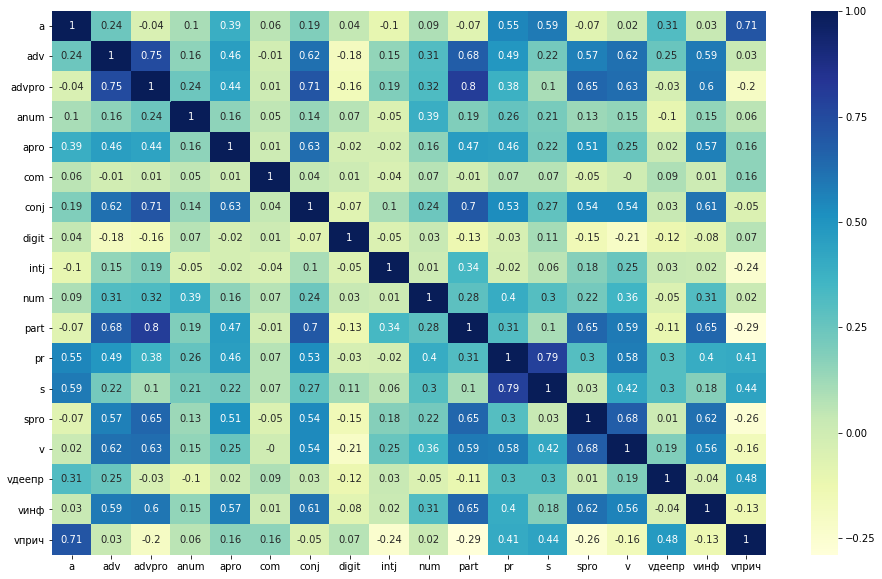

In [311]:
from seaborn import heatmap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,10))    
df = pd.DataFrame(pos_fractions.toarray())
df.columns = sorted(cv_fractions.vocabulary_)
heatmap(df.corr().round(2), annot=True, cmap="YlGnBu")

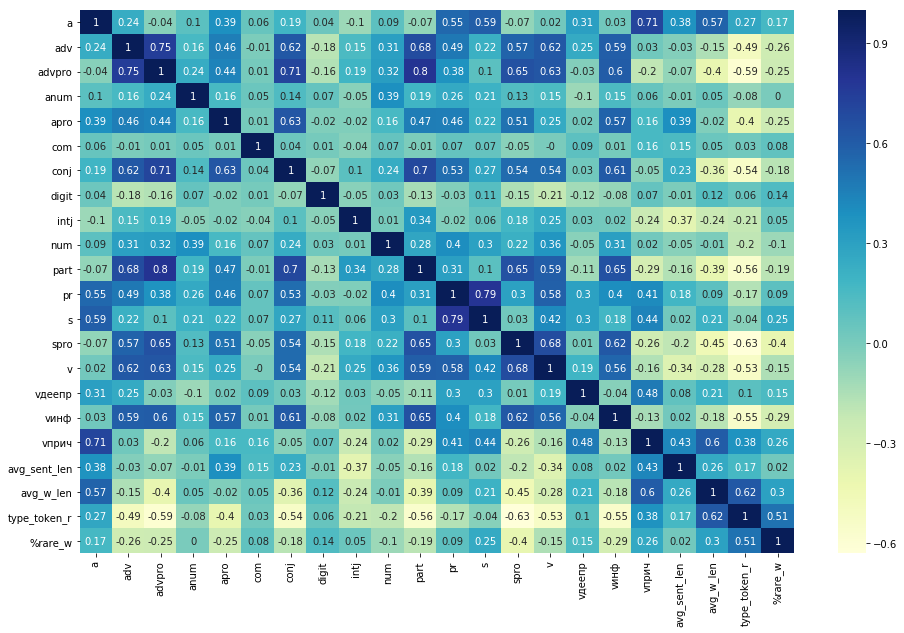

In [63]:
fig, ax = plt.subplots(figsize=(16,10))    
df = pd.DataFrame(np.c_[pos_fractions.todense(), avg_sent_l, avg_len_word, type_token_ratio, rwf])
df.columns = sorted(cv_fractions.vocabulary_)+ ['avg_sent_len', 'avg_w_len', 'type_token_r', '%rare_w']
heatmap(df.corr().round(2), annot=True, cmap="YlGnBu")

In [52]:
from sklearn.metrics.pairwise import pairwise_distances as pdist

In [147]:
pd.DataFrame(pdist(x_train_sc)[0])[y_train!=111].describe()

,0
count,499.000000
mean,124.319933
std,15.275661
min,106.098805
25%,115.516973
50%,119.878037
75%,128.001600
max,254.099090


In [146]:
pd.DataFrame(pdist(x_train_sc[y_train==111]))[0][1:]

1    120.779613
2    109.668382
3    134.608316
Name: 0, dtype: float64

### ITML

In [312]:
from metric_learn import ITML_Supervised

In [394]:
clf = ITML_Supervised(num_constraints=300, verbose=True, convergence_threshold=0.005)

In [395]:
%%time
clf.fit(x_train_sc, y_train)

itml iter: 0, conv = 17.105797
itml iter: 1, conv = 0.584540
itml iter: 2, conv = 0.075097
itml iter: 3, conv = 0.015552
itml converged at iter: 4, conv = 0.003641
CPU times: user 39min 26s, sys: 24min 2s, total: 1h 3min 28s
Wall time: 22min 35s


ITML_Supervised(A0=None, bounds=None, convergence_threshold=0.005, gamma=1.0,
        max_iter=1000, num_constraints=300, num_labeled=inf, verbose=True)

In [396]:
def metric(M):
    return lambda x, y: (x-y).dot(M).dot(x-y)

In [397]:
i_metric = metric(clf.metric())

In [400]:
%%time
pp = []
for p in x_train_sc:
    pp.append(i_metric(x_train_sc[20], p))

CPU times: user 1min 19s, sys: 1.66 s, total: 1min 21s
Wall time: 20.4 s


In [406]:
%%time
dist_matrix = pdist(x_train_sc, metric=i_metric)

CPU times: user 5h 32min 4s, sys: 5min 25s, total: 5h 37min 29s
Wall time: 1h 24min 35s


In [414]:
rp = np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(dist_matrix)))
rp

0.5365095143425163

In [415]:
%%time
test_dist_matrix = pdist(x_test_sc, metric=i_metric)

CPU times: user 26min 31s, sys: 1min 19s, total: 27min 51s
Wall time: 7min 7s


In [527]:
rp_test = np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix)))
rp_test

0.058742857142857145

In [532]:
r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix), verbose=True)

78 [76 56 56] 3 0.0
78 [56 76 87] 3 0.0
78 [76 56 87] 3 0.0
78 [76 56 41] 3 0.0
124 [76 87 56 82] 4 0.0
124 [38 76 82 56] 4 0.0
124 [ 76  87  56 112] 4 0.0
124 [56 76 82 87] 4 0.0
124 [76 82 56 87] 4 0.0
87 [87 76 21] 3 0.3333333333333333
87 [76 56 21] 3 0.0
87 [87 76 82] 3 0.3333333333333333
87 [87 76 56] 3 0.3333333333333333
76 [87] 1 0.0
76 [76] 1 1.0
112 [76 87 82] 3 0.0
112 [76 87 56] 3 0.0
112 [76 87 56] 3 0.0
112 [76 87 82] 3 0.0
21 [76 87 56 56] 4 0.0
21 [87 76 21 82] 4 0.25
21 [87 82 76 21] 4 0.25
21 [76 87 21 56] 4 0.25
21 [87 76 21 82] 4 0.25
139 [76 87 21 82] 4 0.0
139 [76 56 87 82] 4 0.0
139 [76 56 87 82] 4 0.0
139 [76 56 82 87] 4 0.0
139 [76 56 87 82] 4 0.0
41 [76 87 56 82 52] 5 0.0
41 [76 87 82 56 41] 5 0.2
41 [76 56 87 82 41] 5 0.2
41 [76 56 87 82 52] 5 0.0
41 [76 56 82 52 41] 5 0.2
41 [76 56 82 87 52] 5 0.0
102 [76 87 21] 3 0.0
102 [76 56 87] 3 0.0
102 [56 76 87] 3 0.0
102 [76 56 87] 3 0.0
89 [76 87 56 82] 4 0.0
89 [56 76 56 87] 4 0.0
89 [76 56 82 87] 4 0.0
89 [56 76 8

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.0,
 0.3333333333333333,
 0.3333333333333333,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.2,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.2,
 0.4,
 0.4,
 0.2,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.4,
 0.2,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.14285714285714285,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.3333333333333333,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [534]:
pd.DataFrame(test_dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,0.000000,53972.816112,55368.424876,56745.126038,55846.359252,124543.943992,49830.076955,59340.284396,65364.102688,53383.026656,...,52454.706886,47873.617867,48231.151424,49345.081101,52204.214171,47657.211957,53345.215082,53486.807089,60548.328212,50015.901508
1,53972.816112,0.000000,23089.660690,25343.112890,24121.162242,90257.811625,18115.031230,27861.883383,33536.360930,22030.377267,...,20409.512639,16068.252519,16233.294631,17054.796857,20594.003325,15985.237099,21277.629693,21933.802591,28405.953544,18307.615455
2,55368.424876,23089.660690,0.000000,25968.111511,24440.391362,93051.297315,17163.317518,28156.334394,33638.370663,22027.528327,...,20896.355032,16343.887194,17103.770110,16755.271936,20595.377771,16377.842929,21401.942036,21875.903144,28751.351731,18634.993834
3,56745.126038,25343.112890,25968.111511,0.000000,26950.835112,95247.816095,20827.632609,30924.470171,35724.790557,24941.713559,...,23526.482891,19083.855861,19521.381273,20521.001389,23293.834997,18936.498061,24380.888303,24853.531202,31692.663925,21436.595742
4,55846.359252,24121.162242,24440.391362,26950.835112,0.000000,92277.215487,17316.315431,27542.317817,33387.332253,22117.960653,...,20656.597057,15974.328791,16728.996137,17684.065115,20628.255062,16093.411973,21241.825857,21452.154820,28266.056642,18130.275835
5,124543.943992,90257.811625,93051.297315,95247.816095,92277.215487,0.000000,86087.969435,96140.981396,101217.864403,90526.894341,...,89280.091467,84995.197309,85318.541057,86238.988204,89057.476883,82994.986578,90061.646538,90144.386128,95236.096285,86570.438979
6,49830.076955,18115.031230,17163.317518,20827.632609,17316.315431,86087.969435,0.000000,20482.982301,26767.508951,15562.209795,...,14179.826180,9395.740348,10278.359113,11459.637953,13988.421410,9665.248725,15018.356748,15254.090675,21911.062962,11672.782051
7,59340.284396,27861.883383,28156.334394,30924.470171,27542.317817,96140.981396,20482.982301,0.000000,36348.751352,25469.728675,...,24421.484099,19617.059271,20435.835143,21385.537118,24438.422895,19705.983777,25188.311954,25204.663986,31600.696946,21689.514580
8,65364.102688,33536.360930,33638.370663,35724.790557,33387.332253,101217.864403,26767.508951,36348.751352,0.000000,31447.481478,...,29727.015645,25241.439198,26166.487830,27100.059183,30047.953022,25109.871393,30309.961985,30397.229819,37547.616913,27229.268667
9,53383.026656,22030.377267,22027.528327,24941.713559,22117.960653,90526.894341,15562.209795,25469.728675,31447.481478,0.000000,...,17784.033284,13784.219536,14368.071088,15566.564102,17712.711040,13594.149446,19314.399186,19808.758831,25955.481563,15802.136267


In [537]:
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,500,501,502
0,0.000000,7104.524549,5148.987383,7150.907876,7633.400371,8707.182680,10703.383714,5680.865379,5437.516539,8806.719197,...,5940.624268,8463.624185,17159.950162,6052.845673,4947.467496,11677.224157,6335.893553,15497.064509,6329.224331,5550.002225
1,7104.524549,0.000000,4807.915223,6931.598115,7478.034643,8605.841469,10337.160419,5485.105827,5292.676232,8619.921203,...,5562.908636,8418.808543,16867.793160,5682.564162,4765.177726,11299.207153,5969.406629,15196.156941,5961.550404,5447.553327
2,5148.987383,4807.915223,0.000000,4216.449105,5364.717127,6262.999131,8208.782299,3102.474716,2806.244762,6306.797487,...,3473.421057,6295.422660,14794.383507,3368.189373,2500.535184,8652.386668,3929.442027,13119.292990,3926.994329,3014.779225
3,7150.907876,6931.598115,4216.449105,0.000000,7500.705799,8327.161737,10165.564083,5231.209217,4867.508419,8188.684821,...,5615.842279,8107.882094,16865.710888,5281.217782,4619.521258,10632.740874,6008.019714,15275.420382,6006.382913,5006.182030
4,7633.400371,7478.034643,5364.717127,7500.705799,0.000000,9143.324969,10843.913193,5741.403495,5648.139965,9472.849357,...,6317.906069,8983.083802,17899.933722,6396.137943,5275.858777,12031.106250,6536.287455,15658.664758,6527.558568,5800.513081
5,8707.182680,8605.841469,6262.999131,8327.161737,9143.324969,0.000000,11937.083916,6858.774732,6515.877413,10260.998123,...,7223.142059,10173.037381,18985.296474,7377.689406,6377.428722,12752.864628,7818.121482,16904.875029,7817.441919,6805.302576
6,10703.383714,10337.160419,8208.782299,10165.564083,10843.913193,11937.083916,0.000000,8685.223040,8585.885588,12147.072429,...,8953.299147,11863.901711,20220.349271,9331.080589,8105.179925,14582.141729,9627.207737,18985.326729,9624.056690,8837.538071
7,5680.865379,5485.105827,3102.474716,5231.209217,5741.403495,6858.774732,8685.223040,0.000000,3218.429604,7177.229406,...,4073.062207,6773.034774,15746.162739,4122.695969,3185.888020,9603.387779,4328.527303,13653.389386,4321.836862,3554.728477
8,5437.516539,5292.676232,2806.244762,4867.508419,5648.139965,6515.877413,8585.885588,3218.429604,0.000000,6756.114646,...,3909.218809,6612.284893,15169.692954,3927.000462,3048.978145,9485.767943,4141.416079,13317.718665,4135.477984,3264.409610
9,8806.719197,8619.921203,6306.797487,8188.684821,9472.849357,10260.998123,12147.072429,7177.229406,6756.114646,0.000000,...,7320.357576,10067.026513,18534.969169,7425.140390,6403.303790,12447.919229,7996.051358,16923.203051,7993.130687,6898.941646


### Covariance

In [34]:
%%time
inv_matrix = np.linalg.pinv(np.cov(x_train_sc.T))

CPU times: user 17min 35s, sys: 3.37 s, total: 17min 38s
Wall time: 4min 26s


In [35]:
inv_matrix.shape

(7902, 7902)

In [45]:
inv_matrix.max(), inv_matrix.min()

(0.032130412890884405, -0.006481259251888634)

In [317]:
def metric(M):
    return lambda x, y: (x-y).dot(M).dot(x-y)

In [37]:
cov_metric = metric(inv_matrix)

In [49]:
y_train[:10]

array([111,  20,  50,  48,  45,  26,  92,  35,   3,   5])

In [48]:
for i in range(10):
    print(cov_metric(x_train_sc[10], x_train_sc[i]))

1004.0000000000003
1004.0000000000007
1003.9999999999999
1004.0000000000002
1004.0000000000005
1004.0000000000005
1004.0
1004.0000000000003
1003.9999999999999
1004.0000000000005


In [83]:
cov_metric(x_train_sc[4], x_train_sc[5])

1003.9999999999999

In [42]:
cov_metric(x_train_sc[10], x_train_sc[100])

1003.9999999999999

(503, 503)

In [418]:
from sklearn.neighbors import DistanceMetric

In [431]:
%%time
sk_cov_metric = DistanceMetric.get_metric('mahalanobis', V=np.cov(x_train_sc.T))

LinAlgError: Singular matrix

In [ ]:
sk_cov_metric.pairwise([x_train_sc[0], x_train_sc[0]])

In [340]:
def r_precision(dist, books, authors):
    result = []
    for x, y in zip(books, authors):
        true_R = sum(authors == y) - 1
        distances = np.array([dist(x, x_) for x_ in books])
        closest = authors[np.argsort(distances)][1:true_R+1]
        rp = sum(closest == y) / true_R
        print(y, closest, true_R, rp)
        result.append(rp)
    return result

In [214]:
(np.cov(np.array(pp).T))

array([[ 2.,  4.,  6.],
       [ 4.,  8., 12.],
       [ 6., 12., 18.]])

In [216]:
np.array(pp).T

array([[ 1, -1],
       [ 2, -2],
       [ 3, -3]])

|             method            	| train rp 	| test rp 	|
|:-----------------------------:	|:--------:	|:-------:	|
|      cosine delta 100mfw      	|   0.348  	|   0.453  	|
|      cosine delta 500 mfw     	|   0.512  	|   0.574   |
|     cosine delta 1000 mfw     	|   0.537  	|   0.602   |
|     cosine delta 2000 mfw     	|   0.543  	|   0.596   |
|     burrows delta 100 mfw     	|   0.308  	|   0.397  	|
|     burrows delta 500 mfw     	|   0.408  	|   0.500  	|
|     burrows delta 1000 mfw    	|   0.426  	|   0.427  	|
|     burrows delta 2000 mfw    	|   0.428  	|   0.386  	|

|             method            	| train rp 	| test rp 	|
|:-----------------------------:	|:--------:	|:-------:	|
| 1000 mfw z-scores + ITML(300) 	|   0.647  	|  0.304  	|
|            baseline           	|   0.05   	|  0.198  	|
|           ITML(300)           	|   0.536  	|  0.058  	|
|           covariance          	|   error  	|  error  	|
|                               	|          	|         	|
|                               	|          	|         	|

In [ ]:
test cosine delta with 100 mfw: 0.4536380952380952
test cosine delta with 500 mfw: 0.5741333333333333
test cosine delta with 1000 mfw: 0.6023428571428572
test cosine delta with 2000 mfw: 0.596304761904762

test burrows delta with 100 mfw: 0.3967047619047619
test burrows delta with 500 mfw: 0.5002857142857142
test burrows delta with 1000 mfw: 0.4274666666666667
test burrows delta with 2000 mfw: 0.38550476190476196

In [ ]:
def metric(M):
    return lambda x, y: (x-y).dot(M).dot(x-y)

In [ ]:
def r_precision(dist, books, authors):
    
    for x, y in zip(books, authors):
        
        true_R = sum(authors == y) - 1
        
        distances = np.array([dist(x, x_) for x_ in books])
        closest = authors[np.argsort(distances)][1:true_R]
        
        return sum(closest == y) / true_R

In [ ]:
from sklearn.model_selection import GroupKFold
from collections import defaultdictaultdict
def cross_val_score(clf, data, labels, n_splits=3):
    
    result = defaultdict(list)
    result['kf'] = GroupKFold(n_splits=n_splits)

    for train_idx, test_idx in kf.split(data, labels, groups=labels):
        print("iteration")
        train_x, test_x = data[train_idx], data[test_idx]
        train_y, test_y = labels[train_idx], labels[test_idx]
        
        сlf.fit(train_x, train_y)
        result['clf'].append(clf)
        
        dist = metric(clf.metric())
        result['metrics'].append(dist)
        
        r_score_train = r_precision(dist, train_x, train_y)
        result['r_score_train'].append(r_score_train)
        
        r_score_test = r_precision(dist, test_x, test_y)
        result['r_score_test'].append(r_score_test)
    
    return result
    